# Machine Learning

* Load Data, 
* Organize, 
* Test-Train-Split, 
* Linear Regression
* Add Sentiment Analysis
* Analysis of Results
* Conclusions

In [226]:
import pandas as pd
import numpy as np

import io, json
from IPython.display import display

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from textblob import TextBlob as tb
from ipywidgets import interact, fixed

# Load in Data from JSON

In [227]:
#This code can takes a half minute to run.
def load_data(path):
    
    '''
        Pulls up pd.DataFrames saved in the json file specified by the path. 
        
        Args: 
            path (str): address of json file.
        Returns: 
            professors (pd.DataFrame)
            professor_stats (pd.DataFrame)
            professor_stats_by_grade_list (list of pd.DataFrame objects)
            reviews_by_grade (pd.DataFrame)
    
    
    '''
    jsons = open(path, 'r')
    data = json.load(jsons)
    
    professors, professor_stats, stats_by_grade_list, reviews_by_grade = data
    
    professors = pd.read_json(professors, orient='index') #don't drop index
    professor_stats = pd.read_json(professor_stats, orient='index')# drop index
    
    professor_stats_by_grade_list = []
    
    for p in stats_by_grade_list: 
        professor_stats_by_grade_list.append(pd.read_json(p, orient='index'))

    reviews_by_grade = pd.read_json(data[3], orient='index').reset_index(drop=True)
    
    return professors, professor_stats, professor_stats_by_grade_list, reviews_by_grade

In [228]:
path = '/data/primitiveDataType/data.json'
professors, p_stats, reviews_by_grade_list, reviews_by_grade = load_data(path)

In [229]:
assert isinstance(professors, pd.DataFrame)
assert isinstance(p_stats, pd.DataFrame)
assert isinstance(reviews_by_grade_list, list)
assert isinstance(reviews_by_grade, pd.DataFrame)

## Here are the Loaded DataFrames

In [230]:
display(professors.head(3))
display(p_stats.head(3))
display(reviews_by_grade_list[0])
display(reviews_by_grade_list[1])

,Dept,Name,Reporting Evaluations,prof_id
0,Chemistry and Biochemistry,Christina Abel,32,2073
1,Aerospace Engineering,Kira Aberbromby,6,2390
10,Electrical Engineering,Samuel Agbo,54,4


,mean,median,mode,prof_id,rating_type,std_dev
0,3.563,4,4,2073,Overall Rating,0.556
1,3.594,4,4,2073,Presents Material Clearly,0.551
10,3.941,0,4,1,Presents Material Clearly,0.235


,A,B,C,Credit,D,F,N/A,No Credit,prof_id
Overall Rating,3.769,3.222,3.75,NaN,3,NaN,3,NaN,2073
Presents Material Clearly,3.769,3.222,3.75,NaN,3,NaN,4,NaN,2073
Recognizes Student Difficulties,3.692,3.222,3.75,NaN,4,NaN,3,NaN,2073
Reporting Evaluations,13.000,9.000,8.00,NaN,1,NaN,1,NaN,2073


,A,B,C,Credit,D,F,N/A,No Credit,prof_id
Overall Rating,4,4,NaN,NaN,4,NaN,1.5,NaN,2390
Presents Material Clearly,4,3,NaN,NaN,4,NaN,1.5,NaN,2390
Recognizes Student Difficulties,4,4,NaN,NaN,4,NaN,2.0,NaN,2390
Reporting Evaluations,2,1,NaN,NaN,1,NaN,2.0,NaN,2390


## reviews_by_grade
is a DataFrame showing the average ratings grades that students give professors in relation to which grade they earned in the class.

In [231]:
display(reviews_by_grade.head(2))

,Course,Grade,Overall Rating,Presents Material Clearly,Recognizes Student Difficulties,Reporting Evaluations,Review,Year,prof_id,review_id
0,CHEM 124,A,3.769,3.769,3.692,13,"To do well in Abel's class, the key is practic...",Freshman,2073,34359
1,CHEM 127,A,3.769,3.769,3.692,13,Great professor! I learned a lot in her class....,Freshman,2073,34176


# Prepare for Machine Learning

## Question: P( Overall Rating | Grade, Professor) ?
Predict: The Overall Rating given by a student based on his/her Grade and Professor.

Organize a Series y that represents what we are predicting.

Organize X, a DataFrame with numerical/boolean columns that will help predict y.

We can use the reviews_by_grade DataFrame for this. 

Let's not use the "Presents Material Clearly" or the "Recognizes Student Difficulties" Reviews yet to help our predictions. Doing such would undermine the effect of a student's Grade and Professor on his/her rating and we wouldn't have a clear answer to our question. 

In [232]:
#drop nan values
reviews_by_grade.dropna(inplace=True)

#Set y to the column we want to predict.
y = reviews_by_grade['Overall Rating']

y.head()

0    3.769
1    3.769
2    3.769
3    2.800
4    3.400
Name: Overall Rating, dtype: float64

In [233]:
def test_y(y):
    '''
    Performs tests on y values. 
    
    Args: 
        y (pd.Series)
    Returns: 
        None.
    '''
    assert type(y) == pd.Series
    assert type(y.values[0]) == np.float64
    assert np.nan not in y.values
    assert np.isfinite(y.all()) == True

Test the y dependent 'Overall Rating' values. 

In [234]:
test_y(y)

Select columns useful for making the prediction.

In [235]:
# Create a DataFrame solely from the Grade and prof_id columns of reviews_by_grade
X = pd.concat([reviews_by_grade['Grade'], reviews_by_grade['prof_id']], axis=1)
X.head(3)

,Grade,prof_id
0,A,2073
1,A,2073
2,A,2073


The following cell should not be run more than once, else data will be duplicated. 
Get dummy values for the Grades. 

In [236]:
# Concat the dummy values of Grade. Drop Columns that may inhibit the prediction.
X = pd.concat([X, pd.get_dummies(X['Grade']).dropna()], axis=1)
X.drop(['Grade', 'N/A', 'Credit', 'No Credit'], axis=1, inplace=True)
display(X.head())

,prof_id,A,B,C,D,F
0,2073,1,0,0,0,0
1,2073,1,0,0,0,0
2,2073,1,0,0,0,0
3,2,0,1,0,0,0
4,12,0,1,0,0,0


In [237]:
def test_X(X, n_columns):
    '''
    Performs tests on X. 
    
    Args: 
        X (pd.DataFrame): known values
        n_columns (int): number of columns X should have
    Returns: 
        None.
    '''
    
    assert len(X.columns) == n_columns
    assert X.isnull().any().any() == False
    assert np.isinf(X.any().any()) == False
    np.isfinite(X.all())
    
    #Checking a column for infinite values.
    infinites = []

    for i in X.A:
        if np.isinf(i):
            infinites.append(i)

    assert len(infinites) == 0

Test the X feature pd.DataFrame.

In [238]:
test_X(X, 6)
assert np.nan not in X['prof_id'].unique()

## Train -- Test -- Split
Use sklearn.cross_validation.train_test_split to split your data into a training and test set. Save the resulting data in the variables:

* Xtrain 
* Xtest
* ytrain
* ytest

Ideas:
* Don't fill nan prof_id values with the mean. 
* Fill nan Grade values with the professor's mode.

Partitions:
* Train:  80% of Dataset
* Cross-Validation: 10% of Dataset
* Test: 10% of Dataset

In [239]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.10, random_state=0)

print('Train set shapes: ', Xtrain.shape, ytrain.shape)
print('Test set shapes: ', Xtest.shape, ytest.shape)

Train set shapes:  (48833, 6) (48833,)
Test set shapes:  (5426, 6) (5426,)


In [240]:
def test_split_train_test(Xtest, ytest, Xtrain, ytrain):
    '''Performs assert tests on the parameters.
    
       Args: Xtest (pd.DataFrame): Test set to test the Xtrain against
             ytest (pd.Series): Test set to test the ytrain against
             Xtrain (pd.DataFrame): Train set, trained to a model
             ytrain (pd.Series): Train set, trained to a model
       Returns: 
             None.
    '''
    assert Xtrain.shape[0] == ytrain.shape[0]
    assert Xtest.shape[0] == ytest.shape[0]
    

    assert type(ytrain.values[0]) == np.float64
    assert type(ytest.values[0]) == np.float64

    assert np.nan not in ytrain.unique() 

    assert np.isfinite(Xtrain.all().all()) == True
    Xtrain = Xtrain.round(2)

    assert ytrain.dtype == np.float64
    assert np.nan not in ytrain.unique()

In [241]:
test_split_train_test(Xtest, ytest, Xtrain, ytrain)

In [242]:
print('Xtrain: ', display(Xtrain.head()))
print('---------------------------------')
print('ytrain: ', display(ytrain[0:5]))
print('---------------------------------')
print('Xtest: ', display(Xtest.head()))
print('---------------------------------')
print('ytest: ', display(ytest[0:5]))

,prof_id,A,B,C,D,F
42748,1160,1,0,0,0,0
30574,1202,0,0,1,0,0
13119,305,0,1,0,0,0
20541,377,1,0,0,0,0
41967,2830,0,0,1,0,0


Xtrain:  None
---------------------------------


42748    3.692
30574    2.000
13119    1.098
20541    2.899
41967    3.000
Name: Overall Rating, dtype: float64

ytrain:  None
---------------------------------


,prof_id,A,B,C,D,F
22842,3493,1,0,0,0,0
9547,2619,1,0,0,0,0
37966,3032,0,1,0,0,0
17252,1078,0,0,0,0,0
44834,669,0,0,0,1,0


Xtest:  None
---------------------------------


22842    0.667
9547     4.000
37966    2.375
17252    1.048
44834    0.000
Name: Overall Rating, dtype: float64

ytest:  None


# Linear Regression

#### Why Linear Regression? 
Linear Regression alows us to pridict a values that are continuous, unlike Random Forests, and other models that predict discrete values.

* __Construct a model__
* __Fit the model__ to the data
* __Predict__
* Rather than assessing the score, let's __compute the $r^2$ values__ to find the difference between predicted y-values and y-test values.



## Contruct -- Fit -- Predict 

In [243]:
# Instantiate a model
model_lr = LinearRegression()

#Fit the model to the Training Set
model_lr.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [244]:
prediction_lr = model_lr.predict(Xtest)
prediction_lr

array([ 3.42541566,  3.38682214,  2.80973874, ...,  2.76792172,
        2.7990085 ,  2.08468184])

In [245]:
r2_score(prediction_lr, ytest)

-1.1325352055591069

-1.133 $r^2$ Score is a little bleak. This suggests that the linear regression is not a very solid fit. Continuous prediction values are not supported with the sklearn.metrix confusion matrix feature. 
Let's add Sentiment Analysis to see if we can improve the accuracy.

# Add Sentiment Analysis

In [246]:
def process_review(review_text): 
    review = tb(review_text)
    sentiment = review.sentiment
    return [sentiment.polarity, sentiment.subjectivity]

p, s = process_review(reviews_by_grade['Review'][0])
p, s

(0.17954545454545454, 0.5446969696969698)

Tack on the sentiment analysis in two columns onto the reviews_by_grade DataFrame:
* Polarity: [-1, 1] representing how negative or positive a review is.
* Subjectivity [0, 1] representing how subjective a review is.

_This code takes a minute to run._

In [278]:
reviews_by_grade['Sentiment'] = reviews_by_grade['Review'].apply(process_review)
reviews_by_grade['Polarity'] = reviews_by_grade['Sentiment'].map(lambda x: x[0])
reviews_by_grade['Subjectivity'] = reviews_by_grade['Sentiment'].map(lambda x: x[1])
display(reviews_by_grade.head(1))

,Course,Grade,Overall Rating,Presents Material Clearly,Recognizes Student Difficulties,Reporting Evaluations,Review,Year,prof_id,review_id,Sentiment,Polarity,Subjectivity
0,CHEM 124,A,3.769,3.769,3.692,13,"To do well in Abel's class, the key is practic...",Freshman,2073,34359,"[0.17954545454545454, 0.5446969696969698]",0.179545,0.544697


In [279]:
X = pd.concat([reviews_by_grade['Grade'], reviews_by_grade['prof_id'], \
              reviews_by_grade['Polarity'], reviews_by_grade['Subjectivity']], axis=1)
X = pd.concat([X, pd.get_dummies(X['Grade']).dropna()], axis=1)
X.drop(['Grade', 'N/A', 'Credit', 'No Credit', 'Subjectivity'], axis=1, inplace=True)
X.head()

,prof_id,Polarity,A,B,C,D,F
0,2073,0.179545,1,0,0,0,0
1,2073,0.437500,1,0,0,0,0
2,2073,0.366667,1,0,0,0,0
3,2,0.107143,0,1,0,0,0
4,12,-0.086914,0,1,0,0,0


In [261]:
def save_to_json(path, json_str):
    '''
    Saves a DataFrame JSON string to a file.
    Args: path (str): address
    Returns: None.
    '''
    with open(path, 'w') as outfile:
        json.dump(json_str, outfile)
    
# It's a good idea to save this DataFrame      
reviews_by_sentiment_json = reviews_by_grade.reset_index().to_json(orient='index') 
save_to_json('/data/primitiveDataType/reviews_by_grades.json', reviews_by_sentiment_json)

## Test our X and y variables. 

In [287]:
test_X(X, 7)
test_y(y)

## Test -- Train -- Split

In [281]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.10, random_state=0)

print('Train set shapes: ', Xtrain.shape, ytrain.shape)
print('Test set shapes: ', Xtest.shape, ytest.shape)

#Call testing functions
test_X(X, 7)
test_y(y)

Train set shapes:  (48833, 7) (48833,)
Test set shapes:  (5426, 7) (5426,)


## Test the test-train-split values

In [282]:
test_split_train_test(Xtest, ytest, Xtrain, ytrain)

## Contruct -- Fit -- Predict 

In [283]:
# Instantiate a model
model_lr = LinearRegression()

#Fit the model to the Training Set
model_lr.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [284]:
prediction_lr = model_lr.predict(Xtest)
prediction_lr

array([ 3.34117786,  3.35005298,  2.40227555, ...,  2.72610393,
        2.87119226,  2.25752049])

## $r^2$ Score

In [285]:
r2_score(prediction_lr, ytest)

-0.44454273123957933

## Compute 95% and 80% Percentiles of $r^2$

In [275]:
def compute_percentile(q1, q3): 
    '''
    Computes + Plots the values of the percentiles for the ytest 
    subtracted from prediction_lr. 
    
    Args: q1 (float): percentile
          q3 (float): percentile
    Returns: 
        None:
    '''
    
    difference = prediction_lr - ytest
    percentile = np.percentile(difference, (q1, q3))
    print('Percentiles: ', (percentile[0], percentile[1]))
    
    f = plt.figure()
    f.set_size_inches(10, 10, forward=True)
    sns.distplot(prediction_lr - ytest)

    plt.xlabel('Difference = Linear Regression Prediction - ytest', fontsize='20')
    plt.ylabel('Occurrences', fontsize='20')
    plt.title('How Far Off is the Model from the Test Values?', fontsize='20')
#     eightieth_percentile = [-0.926, 1.095]
#     ninety_five_percentile = [-1.482, 1.720]
    
    plt.vlines(percentile, 0, .6, color='b',linestyles='solid')
    plt.show()

Percentiles:  (-0.92572474517114789, 1.0954280847792282)


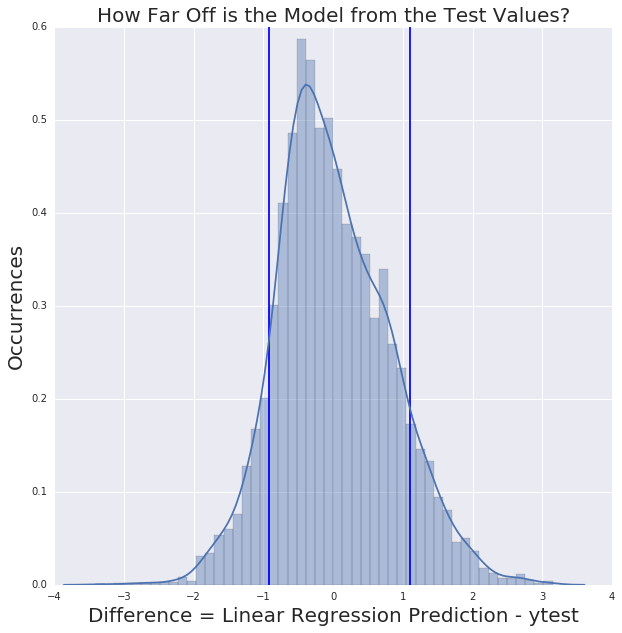

In [277]:
interact(compute_percentile, q1=(0, 15, .5), q3=(85, 100, .5), __manual=True);

# Dashed Black Lines = nth Percentile


# Results

### 80th Percentile: Set q1 to 10 and q3 to 90
The model's prediction is within 1.0 of the test values at the 80th percentile. Differences between the predicted and test values range from: [-0.926, 1.096]

### 95th Percentile: Set q1 to 2.5 and q3 to 97.5
The 95th percentile is shown by the vertical lines. Differences between the predicted and test values range from: [-1.482, 1.720]

This -0.448 $r^2$ score that includes Sentiment Analysis is huge an improvement of -1.133 $r^2$  without sentiment analysis.

If we were to completely guess a professor's Overall Rating without benefitting from any of these features and scikitlearn's Linear Regression model, we would have approximately a 20% chance of guessing accurately. The overall rating is in the ranges of {A: 4, B: 3, C: 2, D: 1, F: 0} 

# Conclusions

The Linear Regression model which offers -0.448 $r^2$ score is is better than the 20% accuracy alternative. 

## This is because you're about 80% confident to be within approximately 1 level of the correct Overall Rating if you use the Linear Regression Model. 

This gives us reason to believe that Review Text Sentiment Analysis amongst a Reviewer's Grade, and the Professor ID help us make a less bad, perhaps even a somewhat good, prediction of the Professor's 'Overall Rating' by reviewers on Polyratings.com.